In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define Prometheus API URL and query
PROMETHEUS_API_URL = "http://10.105.116.175:9090/api/v1/query_range"
PROMETHEUS_QUERY_throughput = ["rate(istio_requests_total{namespace='social-network'}[1m])",
                               "rate(istio_requests_total{namespace='social-network2'}[1m])",
                               "rate(istio_requests_total{namespace='social-network3'}[1m])"]
PROMETHEUS_QUERY_latency_avg = [ "rate(istio_request_duration_milliseconds_sum{namespace='social-network', response_code = '200'}[1m])/ rate(istio_requests_total{namespace='social-network',response_code = '200'}[1m])",
                                 "rate(istio_request_duration_milliseconds_sum{namespace='social-network2',response_code = '200'}[1m])/ rate(istio_requests_total{namespace='social-network2',response_code = '200'}[1m])",
                                  "rate(istio_request_duration_milliseconds_sum{namespace='social-network3',response_code = '200'}[1m])/ rate(istio_requests_total{namespace='social-network3',response_code = '200'}[1m])"]

# PROMETHEUS_QUERY_latency_p95 = "histogram_quantile(0.95, sum(rate(istio_request_duration_milliseconds_bucket{namespace='social-network'}[1m])) by (le))"
# Function to query Prometheus API
def query_prometheus(prometheus_url, query, start, end, step):
    params = {
        'query': query,
        'start': start.timestamp(),
        'end': end.timestamp(),
        'step': step
    }
    response = requests.get(prometheus_url, params=params)
    response.raise_for_status()
    return response.json()

# Function to parse Prometheus response
def parse_prometheus_data(data, check_start_time=None, check_end_time=None):
    results = data['data']['result']
    data_list = []
    for result in results:
        metric = result['metric']
        if 'values' in result:
            for value in result['values']:
                timestamp = datetime.utcfromtimestamp(value[0])
                metric_value = float(value[1])

                if (check_start_time is None or timestamp >= check_start_time) and \
                   (check_end_time is None or timestamp <= check_end_time):
                    data_list.append({
                        "metric": metric,
                        "timestamp": timestamp,
                        "value": metric_value
                    })
        else:
            print(f"No 'values' key found in result: {result}")
    return pd.DataFrame(data_list)



In [2]:


move_back_minutes = 0 # Adjust based on actual query
# check_start_time = datetime.now() - timedelta(minutes=move_back_minutes + 60)  # 20 minutes ago
check_start_time = datetime(2025, 2, 4, 10, 0, 0) # UTC time
check_end_time = datetime(2025, 2, 4, 10, 50, 0)
step = "10s"  # Resolution


# Get current date and time
now = datetime.now()
timestamp = now.strftime("%Y_%b_%d_%H%M")  # Example: 2024_Oct_20_1930

# write a loop to get the data for each query
strategies = ['K8s-burstable','NetMARKS', 'TraDE']
for i in range(0,3):
    # Fetch data from Prometheus
    data_latency_avg = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_latency_avg[i], check_start_time, check_end_time, step)
    df_latency_avg = parse_prometheus_data(data_latency_avg, check_start_time, check_end_time)
    df_latency_avg.to_csv(f'data/{strategies[i]}_{timestamp}_latency.csv', mode='a', header=False, index=False)
    print(f" {strategies[i]} Latency Data has been saved to CSV file")
    
    
    

 K8s-burstable Latency Data has been saved to CSV file
 NetMARKS Latency Data has been saved to CSV file
 TraDE Latency Data has been saved to CSV file


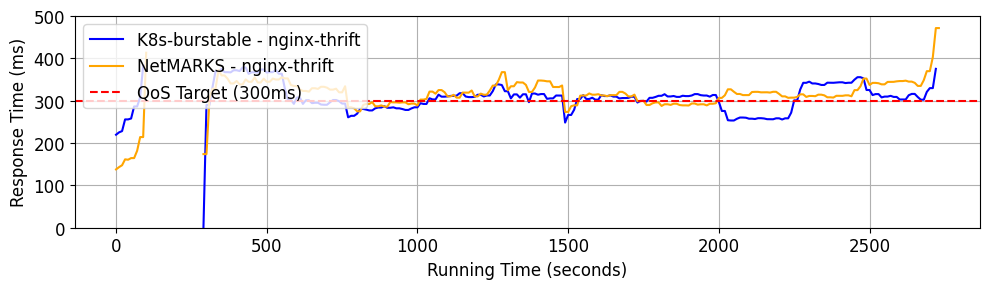

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Assume strategies and timestamp are defined elsewhere, for example:
# strategies = ['strategy1', 'strategy2']
# timestamp = '20250204'
colors = ['blue', 'orange']  # Colors for each strategy

# Create a single figure before the loop
plt.figure(figsize=(10, 3))

for j in range(0, 2):
    # Construct the file path and load the CSV file
    file_path = f'data/{strategies[j]}_{timestamp}_latency.csv'
    df = pd.read_csv(file_path)
    
    # Convert the first column to dictionaries
    df.iloc[:, 0] = df.iloc[:, 0].apply(ast.literal_eval)
    
    # Extract the 'app' key from each dictionary to create a 'metric' column
    df['metric'] = df.iloc[:, 0].apply(lambda x: x.get('app'))
    
    # Convert the second column (assumed to be a timestamp) to datetime
    df['timestamp'] = pd.to_datetime(df[df.columns[1]])
    
    # Calculate elapsed time in seconds from the start of data collection
    df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
    
    if not df.empty:
        # Group the data by the 'metric' column and plot each group
        for key, grp in df.groupby('metric'):
            # To avoid duplicate legend entries when there are multiple groups,
            # you might want to include the metric in the label. If each CSV contains
            # only one metric, you could also simply label with strategies[j].
            plt.plot(grp['elapsed_time'], grp[df.columns[2]],
                     label=f"{strategies[j]} - {key}",
                     color=colors[j])

# Add the QoS target horizontal line (red dashed line at y=300)
plt.axhline(y=300, color='red', linestyle='--', label='QoS Target (300ms)')

# Customize axis fonts and limits
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 500)
plt.xlabel('Running Time (seconds)', fontsize=12)
plt.ylabel('Response Time (ms)', fontsize=12)
plt.grid(True)

# Add a legend to the plot
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

# Finally, display the combined plot
plt.show()


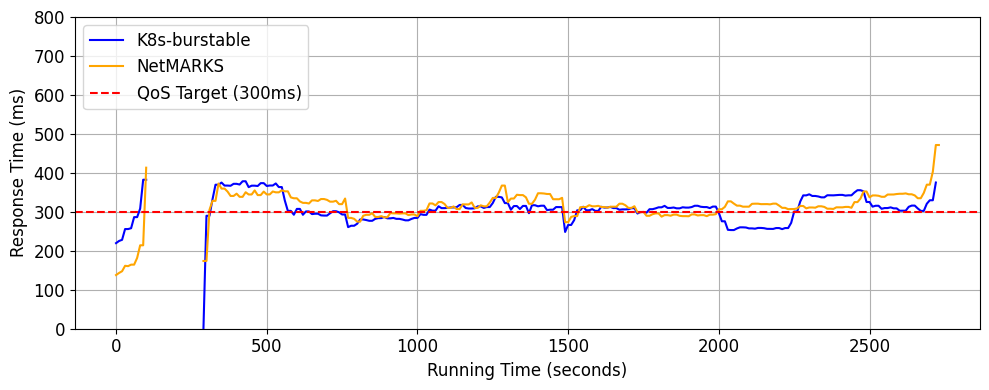

In [7]:
from cProfile import label
import pandas as pd
import matplotlib.pyplot as plt
import ast

colors = ['blue', 'orange', 'green']
strategies = ['K8s-burstable','NetMARKS']  # Ensure strategies list is defined
# timestamp = "..."    # Ensure timestamp is defined

# Create a single figure
plt.figure(figsize=(10, 4))

for j in range(0, 2):
    # Load the CSV file
    file_path = f'data/{strategies[j]}_{timestamp}_latency.csv'
    df = pd.read_csv(file_path)
    # Convert the first column to dictionaries
    df.iloc[:, 0] = df.iloc[:, 0].apply(ast.literal_eval)
    # Extract relevant key-value pairs from the first column, e.g., 'app' as the 'metric'
    df['metric'] = df.iloc[:, 0].apply(lambda x: x.get('app'))
    # Convert the 'timestamp' column to datetime
    df['timestamp'] = pd.to_datetime(df[df.columns[1]])
    # Calculate the elapsed time in seconds from the start of data collection
    df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

    # Plot the data on the existing figure
    if not df.empty:
        for key, grp in df.groupby(['metric']):
            plt.plot(grp['elapsed_time'], grp[df.columns[2]], label=strategies[j], color=colors[j])

# Add common elements to the plot
plt.axhline(y=300, color='red', linestyle='--', label='QoS Target (300ms)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 800)
plt.xlabel('Running Time (seconds)', fontsize=12)
plt.ylabel('Response Time (ms)', fontsize=12)
plt.grid(True)
# Combine legend entries and remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removes duplicate labels
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

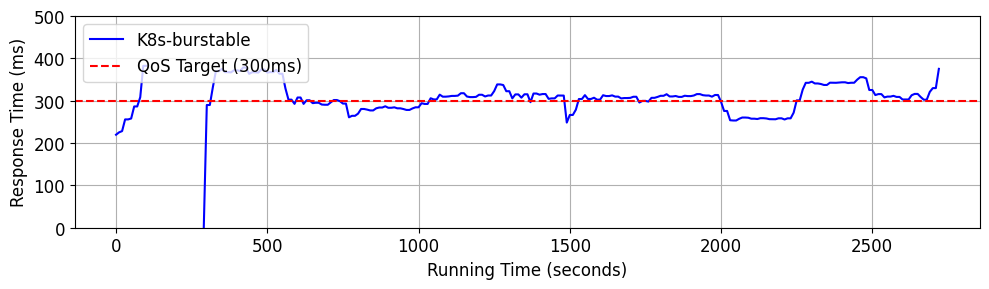

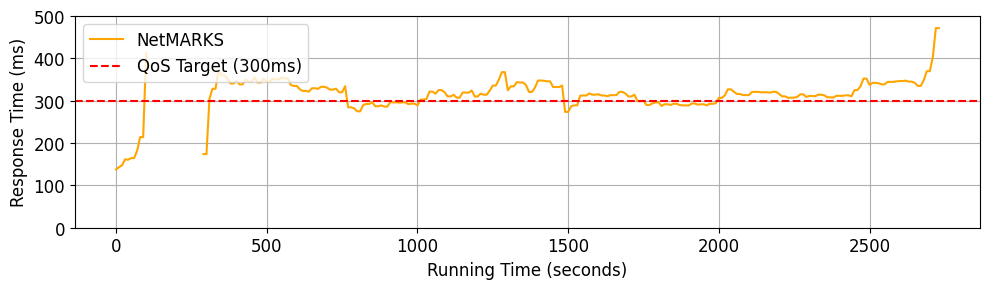

In [4]:
from cProfile import label
import pandas as pd
import matplotlib.pyplot as plt
import ast

colors = ['blue', 'orange', 'green']
for j in range(0, 2):
    # Load the CSV file
    file_path = f'data/{strategies[j]}_{timestamp}_latency.csv'
    df = pd.read_csv(file_path)
    # Convert the first column to dictionaries
    df.iloc[:, 0] = df.iloc[:, 0].apply(ast.literal_eval)
    # Extract relevant key-value pairs from the first column, e.g., 'app' as the 'metric'
    df['metric'] = df.iloc[:, 0].apply(lambda x: x.get('app'))
    # Convert the 'timestamp' column to datetime
    df['timestamp'] = pd.to_datetime(df[df.columns[1]])
    # Calculate the elapsed time in seconds from the start of data collection
    df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

    # Plot the data
    if not df.empty:
        plt.figure(figsize=(10, 3))

        for key, grp in df.groupby(['metric']):
            plt.plot(grp['elapsed_time'], grp[df.columns[2]], label=strategies[j], color=colors[j])
        
        # Add red dashed line (QoS target) at y=300
        plt.axhline(y=300, color='red', linestyle='--', label='QoS Target (300ms)')

        # Set font size for x and y axis
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylim(0, 500)

        plt.xlabel('Running Time (seconds)', fontsize=12)
        plt.ylabel('Response Time (ms)',fontsize=12)
        plt.grid(True)
        plt.legend(loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()  # Display the plot
